In [2]:
!pip install numpy==1.23.5
!pip install scikit-surprise
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831161 sha256=1317527b2365997d43cbbe540e67e72e0047bfe736355ceaacc4aa04785feddf
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

In [4]:
size = "small"

df_behaviors = pd.read_csv(f"MIND{size}_train/behaviors.tsv", sep="\t", names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'])
df_news = pd.read_csv(f"MIND{size}_train/news.tsv", sep="\t", names=['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities'])

In [5]:
df_behaviors.head()

,ImpressionID,UserID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [6]:
df_news.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


## Análisis de df_behaviors

In [7]:
print(f"Número de impresiones: {df_behaviors.shape[0]}")
print(f"Número de usuarios: {df_behaviors['UserID'].nunique()}")

Número de impresiones: 156965
Número de usuarios: 50000


In [8]:
nulos_behaviors = df_behaviors.isnull().sum()[df_behaviors.isnull().sum() > 0].reset_index()
nulos_behaviors.columns = ["Columna", "Cantidad valores nulos"]
nulos_behaviors

,Columna,Cantidad valores nulos
0,History,3238


Un total de 46.065 usuarios no cuentan con historial de navegación (History), lo que indica que se trata de usuarios nuevos en la plataforma. Es importante conservar estos registros en el dataset, ya que reflejan escenarios reales donde el sistema debe ser capaz de generar recomendaciones razonables incluso sin información previa del usuario (problema de cold start en usuarios).

In [9]:
impresiones_por_usuario = df_behaviors["UserID"].value_counts()
impresiones_por_usuario.describe()

,count
count,50000.000000
mean,3.139300
std,3.001026
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,62.000000


<Axes: xlabel='count', ylabel='Count'>

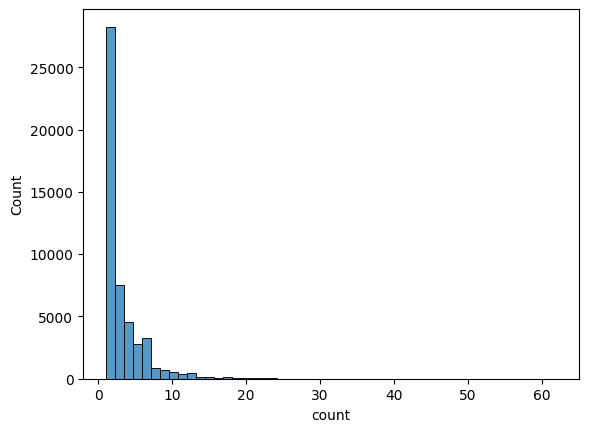

In [10]:
sns.histplot(impresiones_por_usuario, bins = 50)

In [11]:
for i in range(1, 8):
    j = i * 10
    print(f"Usuarios con mas de {j} impresiones: {len(impresiones_por_usuario[impresiones_por_usuario > j])}")

Usuarios con mas de 10 impresiones: 1562
Usuarios con mas de 20 impresiones: 150
Usuarios con mas de 30 impresiones: 25
Usuarios con mas de 40 impresiones: 3
Usuarios con mas de 50 impresiones: 1
Usuarios con mas de 60 impresiones: 1
Usuarios con mas de 70 impresiones: 0


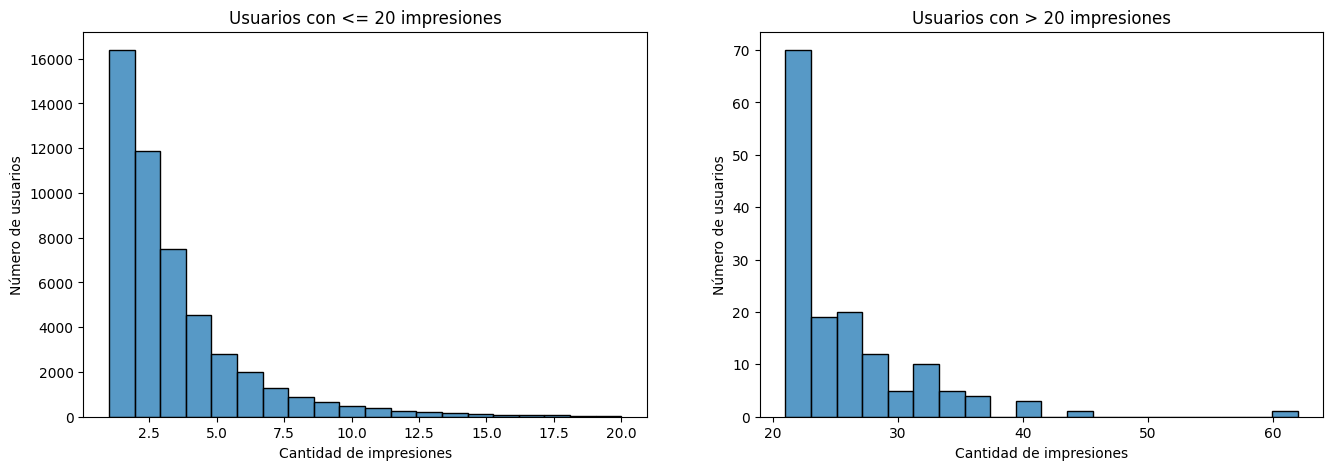

In [12]:
grupo_1 = impresiones_por_usuario[impresiones_por_usuario <= 20]
grupo_2 = impresiones_por_usuario[impresiones_por_usuario > 20]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(grupo_1, bins = 20, ax=axes[0])
axes[0].set_title("Usuarios con <= 20 impresiones")
axes[0].set_xlabel("Cantidad de impresiones")
axes[0].set_ylabel("Número de usuarios")

sns.histplot(grupo_2, bins = 20, ax=axes[1])
axes[1].set_title("Usuarios con > 20 impresiones")
axes[1].set_xlabel("Cantidad de impresiones")
axes[1].set_ylabel("Número de usuarios")

plt.show()

In [13]:
df_behaviors["Time"] = pd.to_datetime(df_behaviors["Time"])
df_behaviors["Date"] = df_behaviors["Time"].dt.date

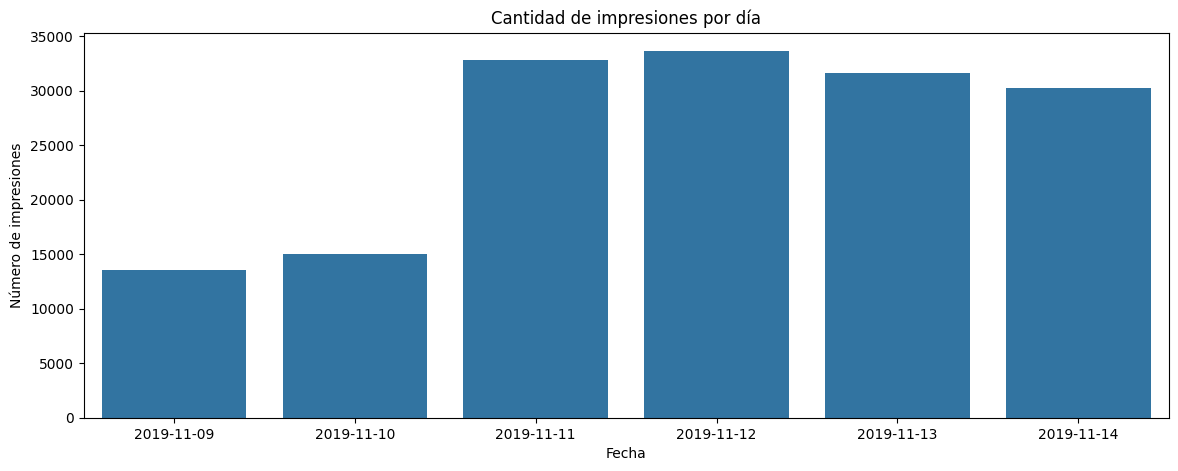

In [14]:
conteo_por_dia = df_behaviors["Date"].value_counts().sort_index()
df_fechas = conteo_por_dia.reset_index()
df_fechas.columns = ["Date", "Impressions"]

plt.figure(figsize=(14, 5))
sns.barplot(data=df_fechas, x = "Date", y = "Impressions")

plt.title("Cantidad de impresiones por día")
plt.xlabel("Fecha")
plt.ylabel("Número de impresiones")
plt.show()

Interesante saber que el dataset solo tiene 6 días de interacciones

In [15]:
df_behaviors["HistoryLength"] = df_behaviors["History"].fillna("").apply(lambda x: len(x.split()))

In [16]:
df_behaviors["HistoryLength"].describe().apply(lambda x: f"{x:.2f}")

,HistoryLength
count,156965.00
mean,32.54
std,40.27
min,0.00
25%,8.00
50%,19.00
75%,42.00
max,558.00


In [17]:
num_interacciones = df_behaviors["Impressions"].apply(lambda x: len(x.split())).sum()

In [18]:
print(f"Número total de interacciones: {num_interacciones:,}")

Número total de interacciones: 5,843,444


### Creación de dataset típico de recomendación

In [19]:
interacciones = []

for _, row in df_behaviors.iterrows():
    user_id = row["UserID"]
    timestamp = row["Time"]
    impressions = row["Impressions"].split()

    for impression in impressions:
        news_id, clicked = impression.split('-')
        interacciones.append({
            "UserID": user_id,
            "NewsID": news_id,
            "Clicked": int(clicked),
            "Timestamp": timestamp
        })

df_interacciones = pd.DataFrame(interacciones)

In [20]:
df_interacciones

,UserID,NewsID,Clicked,Timestamp
0,U13740,N55689,1,2019-11-11 09:05:58
1,U13740,N35729,0,2019-11-11 09:05:58
2,U91836,N20678,0,2019-11-12 18:11:30
3,U91836,N39317,0,2019-11-12 18:11:30
4,U91836,N58114,0,2019-11-12 18:11:30
...,...,...,...,...
5843439,U44625,N39317,0,2019-11-13 14:57:02
5843440,U64800,N61233,0,2019-11-14 15:25:49
5843441,U64800,N33828,1,2019-11-14 15:25:49
5843442,U64800,N19661,0,2019-11-14 15:25:49


In [21]:
noticias_clickeadas_por_usuario = df_interacciones.groupby("UserID")["Clicked"].agg(["count", "sum"]).reset_index()

In [22]:
noticias_clickeadas_por_usuario["porcentaje noticias vistas"] = noticias_clickeadas_por_usuario["sum"] / noticias_clickeadas_por_usuario["count"]
noticias_clickeadas_por_usuario["porcentaje noticias vistas"] = (noticias_clickeadas_por_usuario["porcentaje noticias vistas"] * 100).apply(lambda x: f"{x:.2f}%")

In [23]:
noticias_clickeadas_por_usuario

,UserID,count,sum,porcentaje noticias vistas
0,U100,105,1,0.95%
1,U1000,205,4,1.95%
2,U10001,84,3,3.57%
3,U10003,106,3,2.83%
4,U10008,72,1,1.39%
...,...,...,...,...
49995,U9993,55,2,3.64%
49996,U9995,236,11,4.66%
49997,U9996,19,3,15.79%
49998,U9997,133,7,5.26%


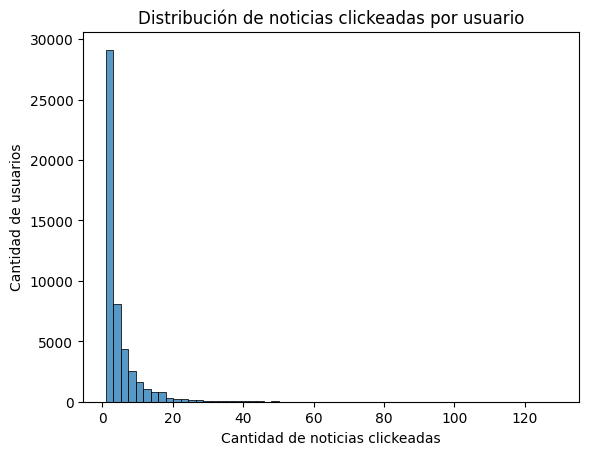

In [24]:
sns.histplot(noticias_clickeadas_por_usuario["sum"], bins = 60)
plt.title("Distribución de noticias clickeadas por usuario")
plt.xlabel("Cantidad de noticias clickeadas")
plt.ylabel("Cantidad de usuarios")
plt.show()

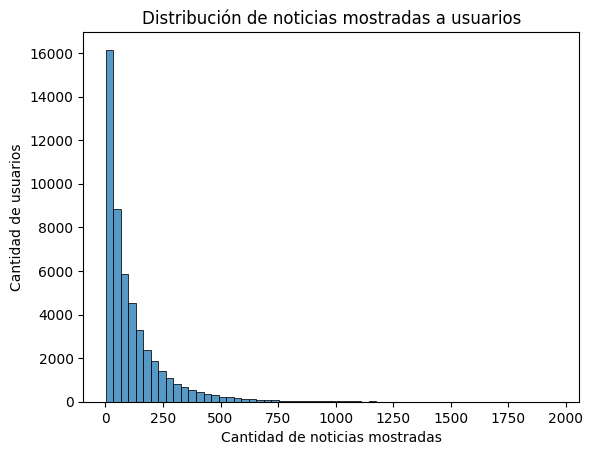

In [25]:
sns.histplot(noticias_clickeadas_por_usuario["count"], bins = 60)
plt.title("Distribución de noticias mostradas a usuarios")
plt.xlabel("Cantidad de noticias mostradas")
plt.ylabel("Cantidad de usuarios")
plt.show()

In [26]:
noticias_clickeadas_por_usuario[noticias_clickeadas_por_usuario["sum"] == 0]

,UserID,count,sum,porcentaje noticias vistas


Todos los usuarios clickearon al menos una noticia

In [27]:
noticias_clickeadas_por_usuario[noticias_clickeadas_por_usuario["count"] == 0]

,UserID,count,sum,porcentaje noticias vistas


Todos los usuarios vieron al menos una noticia

## Análisis de df_news

In [28]:
df_news.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [29]:
print(f"Número de noticias: {df_news['NewsID'].nunique()}")
print(f"Número de categorías: {df_news['Category'].nunique()}")
print(f"Categorías: {df_news['Category'].unique().tolist()}")
print(f"Número de SubCategorías: {df_news['SubCategory'].nunique()}")

Número de noticias: 51282
Número de categorías: 17
Categorías: ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music', 'kids', 'middleeast', 'northamerica']
Número de SubCategorías: 264


In [30]:
nulos_news = df_news.isnull().sum()[df_news.isnull().sum() > 0].reset_index()
nulos_news.columns = ["Columna", "Cantidad valores nulos"]
nulos_news

,Columna,Cantidad valores nulos
0,Abstract,2666
1,TitleEntities,3
2,AbstractEntities,4


In [31]:
df_news["Abstract"] = df_news["Abstract"].fillna("")
df_news["TitleEntities"] = df_news["TitleEntities"].fillna("[]")
df_news["AbstractEntities"] = df_news["AbstractEntities"].fillna("[]")

Se rellenan los valores debido a que es una cantidad importante de las noticias del dataset

In [32]:
df_news["AbstractEntities"][1]

'[{"Label": "Adipose tissue", "Type": "C", "WikidataId": "Q193583", "Confidence": 1.0, "OccurrenceOffsets": [97], "SurfaceForms": ["belly fat"]}]'

## Recomendadores

In [33]:
df_interacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5843444 entries, 0 to 5843443
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   UserID     object        
 1   NewsID     object        
 2   Clicked    int64         
 3   Timestamp  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 178.3+ MB


In [34]:
cutoff = pd.to_datetime("2019-11-14")
train = df_interacciones[df_interacciones["Timestamp"] < cutoff]
val   = df_interacciones[df_interacciones["Timestamp"] >= cutoff]

In [35]:
print(f"El dataset de entrenamiento tiene un {(train.shape[0] / df_interacciones.shape[0]) * 100:.2f}% de los datos")
print(f"El dataset de validación tiene un {(val.shape[0] / df_interacciones.shape[0]) * 100:.2f}% de los datos")

El dataset de entrenamiento tiene un 79.08% de los datos
El dataset de validación tiene un 20.92% de los datos


In [36]:
noticias_disponibles = train["NewsID"].unique()

In [37]:
from collections import defaultdict

clicks_verdaderos = defaultdict(set)

for _, row in val[val["Clicked"] == 1].iterrows():
    clicks_verdaderos[row["UserID"]].add(row["NewsID"])

In [38]:
def recomendar_random(noticias, k=10):
    return np.random.choice(noticias, size=k, replace=False).tolist()

recomendaciones = {
    user: recomendar_random(noticias_disponibles, k=10)
    for user in clicks_verdaderos.keys()
}

In [39]:
recall_sum = 0

for user, reales in clicks_verdaderos.items():
    predichas = set(recomendaciones[user])
    hits = len(predichas & reales)
    recall_sum += hits / len(reales)

recall_at_10 = recall_sum / len(clicks_verdaderos)
print(f"Recall@10 del recomendador aleatorio: {recall_at_10:.4f}")

Recall@10 del recomendador aleatorio: 0.0003


### Most Popular

In [40]:
popularidad = (train[train["Clicked"] == 1].groupby("NewsID").size().sort_values(ascending=False)
)

top_noticias = popularidad.index.tolist()  # Noticias ordenadas de más a menos populares

In [41]:
recomendaciones_populares = {
    user: top_noticias[:10]
    for user in clicks_verdaderos.keys()  # los mismos usuarios con ground truth que usaste antes
}

In [42]:
recall_sum = 0

for user, reales in clicks_verdaderos.items():
    predichas = set(recomendaciones_populares[user])
    hits = len(predichas & reales)
    recall_sum += hits / len(reales)

recall_at_10_popular = recall_sum / len(clicks_verdaderos)
print(f"Recall@10 del recomendador por popularidad: {recall_at_10_popular:.4f}")


Recall@10 del recomendador por popularidad: 0.0001


In [43]:
# Crear diccionario de popularidad
popularidad_dict = popularidad.to_dict()

# Recomendaciones populares entre las noticias que realmente se le mostraron a cada usuario
recomendaciones_populares_filtradas = {}

# Agrupar validación por usuario y timestamp
for (user, timestamp), group in train.groupby(["UserID", "Timestamp"]):
    noticias_mostradas = group["NewsID"].tolist()

    # Ordenar las noticias por popularidad (entre las mostradas)
    ordenadas = sorted(noticias_mostradas, key=lambda x: popularidad_dict.get(x, 0), reverse=True)

    recomendaciones_populares_filtradas[user] = ordenadas[:10]  # top-10 entre sus opciones

In [44]:
recall_sum = 0

for user, reales in clicks_verdaderos.items():
    predichas = set(recomendaciones_populares_filtradas.get(user, []))
    hits = len(predichas & reales)
    recall_sum += hits / len(reales)

recall_at_10_pop_filtrado = recall_sum / len(clicks_verdaderos)
print(f"Recall@10 del recomendador por popularidad (filtrado): {recall_at_10_pop_filtrado:.4f}")


Recall@10 del recomendador por popularidad (filtrado): 0.0045


In [45]:
# # Surprise requiere estas columnas: user, item, rating
# # En nuestro caso, rating = Clicked (0 o 1)
# reader = Reader(rating_scale=(0, 1))
# data = Dataset.load_from_df(train[["UserID", "NewsID", "Clicked"]], reader)

# # Usamos nuestra propia división train/val si ya la tienes:
# trainset = data.build_full_trainset()  # si quieres usar todos los datos

In [46]:
# from surprise import KNNBasic

# sim_options = {
#     "name": "pearson_baseline",
#     "user_based": False
# }

# model = KNNBasic(sim_options=sim_options, k=20)
# model.fit(trainset)

In [47]:
# user_id = "U13740"
# news_candidatas = val[val["UserID"] == user_id]["NewsID"].unique()

# # Predecir score para cada noticia
# predicciones = [model.predict(user_id, news_id) for news_id in news_candidatas]

# # Ordenar por score y tomar las top 10
# top_10 = sorted(predicciones, key=lambda x: x.est, reverse=True)[:10]
# recomendadas = [pred.iid for pred in top_10]


In [48]:
# from collections import defaultdict

# # Ground truth
# clicks_verdaderos_val = val[val["Clicked"] == 1].groupby("UserID")["NewsID"].apply(set).to_dict()
# usuarios_val = val["UserID"].unique()

# recall_total = 0
# usuarios_con_clics = 0

# for user in usuarios_val:
#     reales = clicks_verdaderos_val.get(user, set())
#     if len(reales) == 0:
#         continue

#     news_candidatas = val[val["UserID"] == user]["NewsID"].unique()
#     preds = [model.predict(user, item) for item in news_candidatas]
#     top_10 = sorted(preds, key=lambda x: x.est, reverse=True)[:10]
#     predichas = set([p.iid for p in top_10])

#     hits = len(predichas & reales)
#     recall_total += hits / len(reales)
#     usuarios_con_clics += 1

# recall_surprise = recall_total / usuarios_con_clics
# print(f"Recall@10 con UserKNN (surprise): {recall_surprise:.4f}")


In [49]:
from lightfm import LightFM
from lightfm.data import Dataset

# Crear dataset y matriz de interacciones
dataset = Dataset()
dataset.fit(train["UserID"], train["NewsID"])

interactions, _ = dataset.build_interactions(
    train[train["Clicked"] == 1][["UserID", "NewsID"]].values
)

model = LightFM(loss="bpr")
model.fit(interactions, epochs=10, num_threads=4)

In [53]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

# Diccionarios inversos para decodificar índices
idx_to_user = {v: k for k, v in user_id_map.items()}
idx_to_item = {v: k for k, v in item_id_map.items()}

In [55]:
import numpy as np
from collections import defaultdict

# Ground truth de validación
clicks_val = val[val["Clicked"] == 1].groupby("UserID")["NewsID"].apply(set).to_dict()
usuarios_val = val["UserID"].unique()

recomendaciones_lfm = {}

for user in usuarios_val:
    if user not in user_id_map:
        recomendaciones_lfm[user] = []
        continue

    user_idx = user_id_map[user]
    scores = model.predict(user_idx, np.arange(len(item_id_map)))

    # Filtrar ítems ya vistos en entrenamiento
    vistos = train[train["UserID"] == user]["NewsID"].unique()
    vistos_idx = [item_id_map[i] for i in vistos if i in item_id_map]
    scores[vistos_idx] = -np.inf

    # Top 10 recomendaciones
    top_items_idx = np.argsort(-scores)[:10]
    recomendaciones_lfm[user] = [idx_to_item[i] for i in top_items_idx]


KeyboardInterrupt: 

In [ ]:
recall_total = 0
usuarios_con_clics = 0

for user, reales in clicks_val.items():
    pred = set(recomendaciones_lfm.get(user, []))
    if len(reales) == 0:
        continue
    hits = len(pred & reales)
    recall_total += hits / len(reales)
    usuarios_con_clics += 1

recall_lfm = recall_total / usuarios_con_clics
print(f"Recall@10 del modelo LightFM: {recall_lfm:.4f}")
